In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

plt.rcParams.update({
    "text.usetex": True,          # Use LaTeX for all text
    "font.family": "serif",       # Use serif font (LaTeX default)
    "font.size": 20,              # Font size
})

In [2]:
# PARAMETERS
N = 5000
L = 5

In [3]:
def plot(omega, save=False, filename="", title=""):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    skip = 3
    ax.plot_surface(X, Y, omega, cmap='inferno', edgecolor='none', antialiased=True)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$\omega$")
    if title: ax.set_title(title)

    if save:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [4]:
# SPATIAL GRID
x = np.linspace(-L/2, L/2, N, endpoint=False)
y = np.linspace(-L/2, L/2, N, endpoint=False)

X, Y = np.meshgrid(x, y, indexing='ij')

kx = np.fft.fftfreq(N) * N
ky = np.fft.fftfreq(N) * N
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2 # |k|^2
K2[0,0] = 1.0

def R12(f):
    """Compute R1^2 f using FFT."""
    f_hat = np.fft.fft2(f)
    symbol = -(KX * KY / K2) # symbol of R1^2
    symbol[0,0] = 0.0
    out = np.fft.ifft2(symbol * f_hat).real
    return out


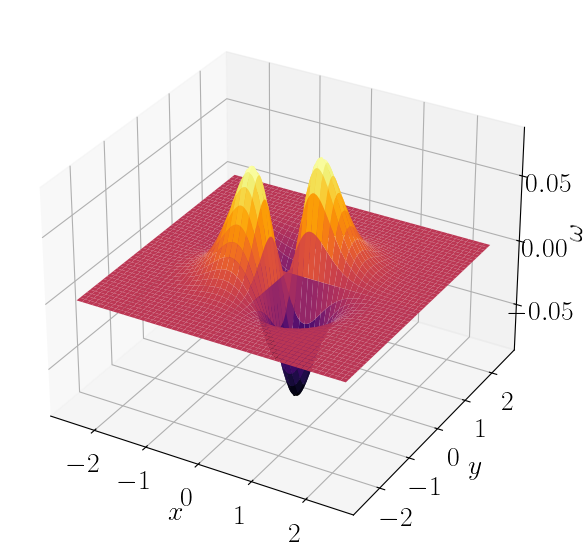

In [5]:
# INITIAL CONDITION
r2 = X**2 + Y**2
W2 = 1 / (1 + r2) ** 3
omega0 = R12(W2) * np.exp(-r2)
plot(omega0, save=True, filename="plots/2d/R12_R/R12_initial_condition.pdf")
# plot(omega0, save=True, filename="R12_R/R12_initial_condition.pdf")

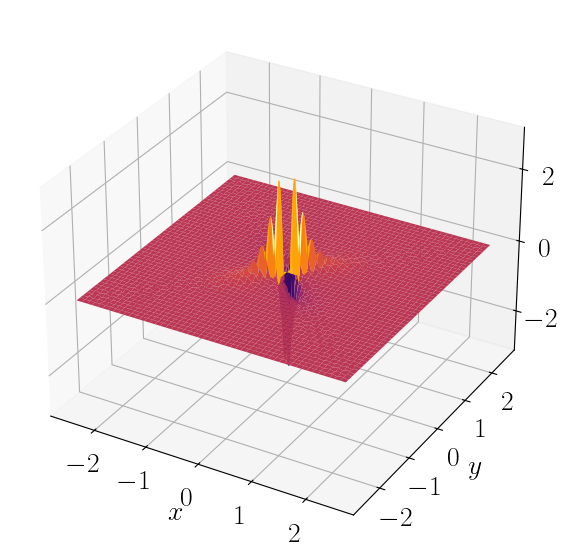

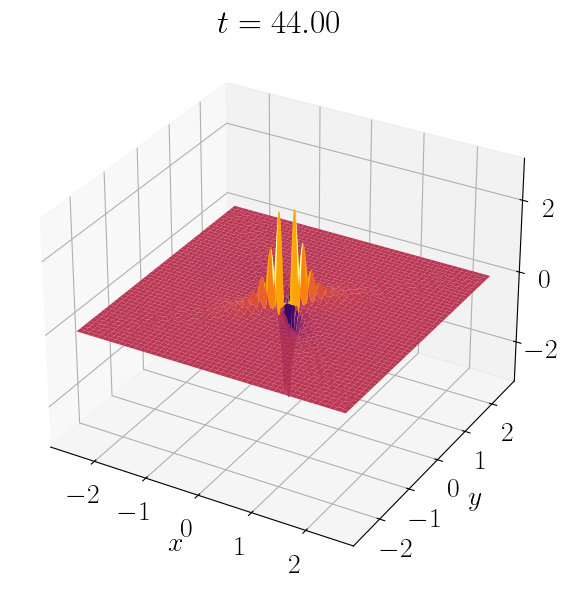

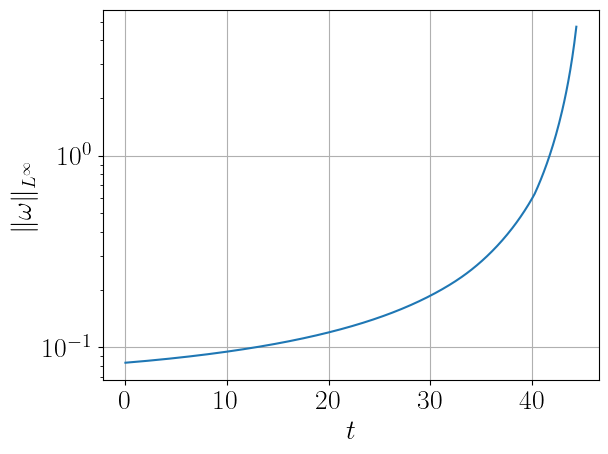

In [6]:
omega = omega0.copy()
T = 44.5
dt = 0.1
nsteps = int(T / dt)

k_cut = N / 3.0
dealias_mask = np.abs(K2) <= k_cut

def get_rhs(w):
    nonlin = w * R12(w)
    nonlin_hat = np.fft.fft2(nonlin)
    nonlin_hat[~dealias_mask] = 0.0
    nonlin = np.real(np.fft.ifft2(nonlin_hat))

    return nonlin

maxs = []
rk4 = True
for n in range(nsteps):
    if rk4:
        k1 = get_rhs(omega)
        k2 = get_rhs(omega + 0.5 * dt * k1)
        k3 = get_rhs(omega + 0.5 * dt * k2)
        k4 = get_rhs(omega + dt * k3)

        omega += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    else:
        omega += get_rhs(omega) * dt

    maxs.append(np.max(np.abs(omega)))
    if (n + 1) % 10 == 0:
        print(f"Step {n + 1}/{nsteps}")
        clear_output(wait=True)
        plot(omega, save=True, filename=f"plots/2d/R12_R{"_rk4"*rk4}/R12_step_{n+1}.pdf")
        plot(omega, save=True, filename=f"plots/2d/R12_R{"_rk4"*rk4}/time/R12_step_{n+1}_with_timestamp.pdf", title=rf"$t={(n + 1) * dt:.2f}$")

plt.plot(np.arange(nsteps) * dt, maxs)
plt.grid()
plt.xlabel(r"$t$")
plt.ylabel(r"$\|\omega\|_{L^{\infty}}$")
plt.yscale('log')
plt.savefig(f"plots/2d/R12_R{"_rk4"*rk4}/R12_max_omega.pdf", bbox_inches='tight')
plt.show()

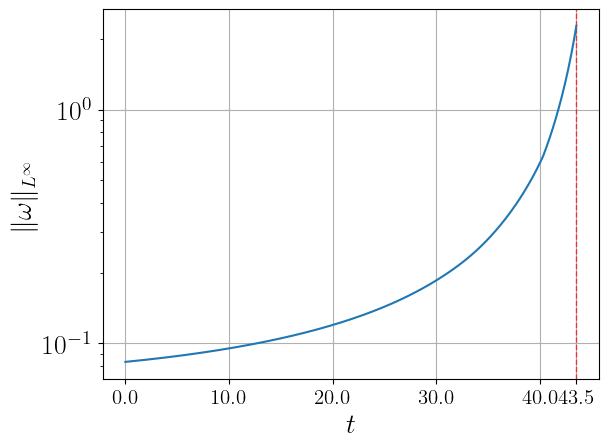

In [7]:
times = np.arange(nsteps) * dt
plt.axvline(x=43.5, color='r', linestyle='--', alpha=0.7, linewidth=1)
plt.plot(times[:-9], maxs[:-9])
plt.grid()
plt.xlabel(r"$t$")
plt.ylabel(r"$\|\omega\|_{L^{\infty}}$")
plt.yscale('log')
plt.xticks([0, 10, 20, 30, 40, 43.5], fontsize=15)
# plt.yticks([0, 100, 200, 300, 400, 500, 600, 700], fontsize=16)
plt.savefig(f"plots/2d/R12_R{"_rk4"*rk4}/R12_max_omega.pdf", bbox_inches='tight')
plt.show()